In [1]:
#code to compare rainfall from 2 different WRF simulations (I originally used it for comparing a simulation with hi-resolution terrain vs lo-res terrain)
#basic plots for a specified domain, and for an averaging box defined by lats/lons

In [9]:
import os
import subprocess
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.cbook as cbook
from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

import pandas as pd
import xarray as xr
import numpy as np
import math
from numpy import *
from pylab import *
import pygrib
import pyproj

from siphon.catalog import TDSCatalog
from siphon.http_util import session_manager
from datetime import datetime, timedelta
from xarray.backends import NetCDF4DataStore
from netCDF4 import Dataset
import metpy as metpy
import metpy.calc as mpcalc
from metpy.plots import ctables
from metpy.units import units
from metpy.plots import add_metpy_logo, add_timestamp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter

import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from cartopy import config
import wrf
from wrf import (to_np, interplevel, geo_bounds, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords,ll_to_xy)
import glob

1
/scratch/amanda/ivan_hires_ctrl_3dom_30s_terr/wrfout_d03_2004-09-19_00:00:00
WRF valid time:  2004-09-19_00


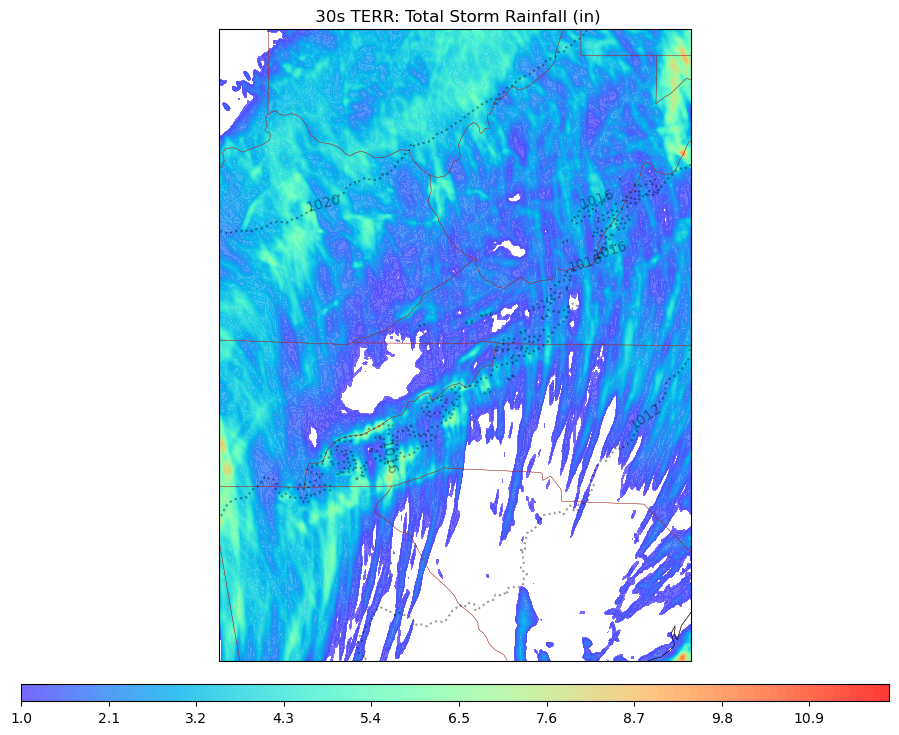

<xarray.DataArray ()>
array(11.214487, dtype=float32)
Coordinates:
    XTIME    float32 7.92e+03
    Time     datetime64[ns] 2004-09-19


In [19]:
#FILE 1

# Set up for saving graphics files, create directory for plots, if needed
plotsdir = '/home/jupyter-amsinnin@ncsu.edu/Ivan/Ivan_ctrl_plots/difference_totalrain'
if os.path.isdir(plotsdir) != 1:
    subprocess.call(["mkdir","-p",plotsdir])
os.chdir(plotsdir)

#get files
datafiles = (glob.glob("/scratch/amanda/ivan_hires_ctrl_3dom_30s_terr/wrfout_d03_2004-09-19_00:00:00"))
datafiles.sort()
numfiles=len(datafiles)
print(numfiles)
print(datafiles[0])


ivan_slp=[]
ivan_rain=[]
ivan_runoff=[]
filetimes=[]
for j in range(0,numfiles):
    ncfile = Dataset(datafiles[j])
    Time=wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    timestr=(str(Time))
    # Set up one time string for plot titles, another for file names
    titletime=(timestr[0:10]+' '+timestr[11:16])
    filetime=(timestr[0:10]+'_'+timestr[11:13])
    print('WRF valid time: ',filetime)
    #print(ncfile)
    
    # Get all the variables we need
    z = getvar(ncfile, "z")
    dbz3 =getvar(ncfile, "dbz")
    p = getvar(ncfile, "pressure")
    slp = getvar(ncfile, "slp")
    rainc = getvar(ncfile, "RAINC")
    rainnc = getvar(ncfile, "RAINNC")
    lats = ncfile.variables['XLAT'][0,:,:]
    lons = ncfile.variables['XLONG'][0,:,:]
    hires_terr= ncfile.variables["HGT"][0,:,:] #terrain height for the 30s terr resolution
    
    raintot = (rainc + rainnc)*0.0393701 #in inches
    
    ivan_rain.append(raintot)
    filetimes.append(filetime)
    
    # Download and add the states and coastlines
    states = NaturalEarthFeature(category="cultural", scale="50m",facecolor="none", name="admin_1_states_provinces_shp")
    # Smooth the sea level pressure since it tends to be noisy near complex terrain
    smooth_slp = smooth2d(slp, 3, cenweight=4)
    ivan_slp.append(smooth_slp)

    plotproj = crs.Mercator()
    fig = plt.figure(figsize=(14,10))
    ax=plt.subplot(111, projection=plotproj)
    ax.set_extent([-85.5, -79, 33, 40],crs.PlateCarree())
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.25, edgecolor='brown')
    ax.coastlines('50m', linewidth=0.4)
    
    #add contours
    rain_levels = np.arange(1, 12, 0.1)
    pmsl_levels = np.arange(900, 1060, 4)
    contours = plt.contour(to_np(lons), to_np(lats), to_np(smooth_slp), levels=pmsl_levels, colors="black", alpha= .4, linestyles='dotted',transform=crs.PlateCarree())
    plt.clabel(contours, inline=1, fontsize=10, fmt="%i") 
    
    rain_contours = plt.contourf(to_np(lons), to_np(lats), to_np(raintot), levels=rain_levels,
                             cmap=get_cmap("rainbow"),norm=Normalize(0,12), vmin=0, vmax=12, alpha=.8,transform=crs.PlateCarree())
    plt.colorbar(rain_contours, ax=ax, orientation="horizontal", pad=.03, shrink=.8, aspect=50)

    plt.title(" 30s TERR: Total Storm Rainfall (in)")
    
    # Create separate plot file and save as .png, then show and close
    plt.savefig('plot_hrterr_d03_'+filetime+'.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()
    print(np.max(raintot))

1
/scratch/amanda/ivan_lores_10m_terr/wrfout_d03_2004-09-19_00:00:00
WRF valid time:  2004-09-19_00


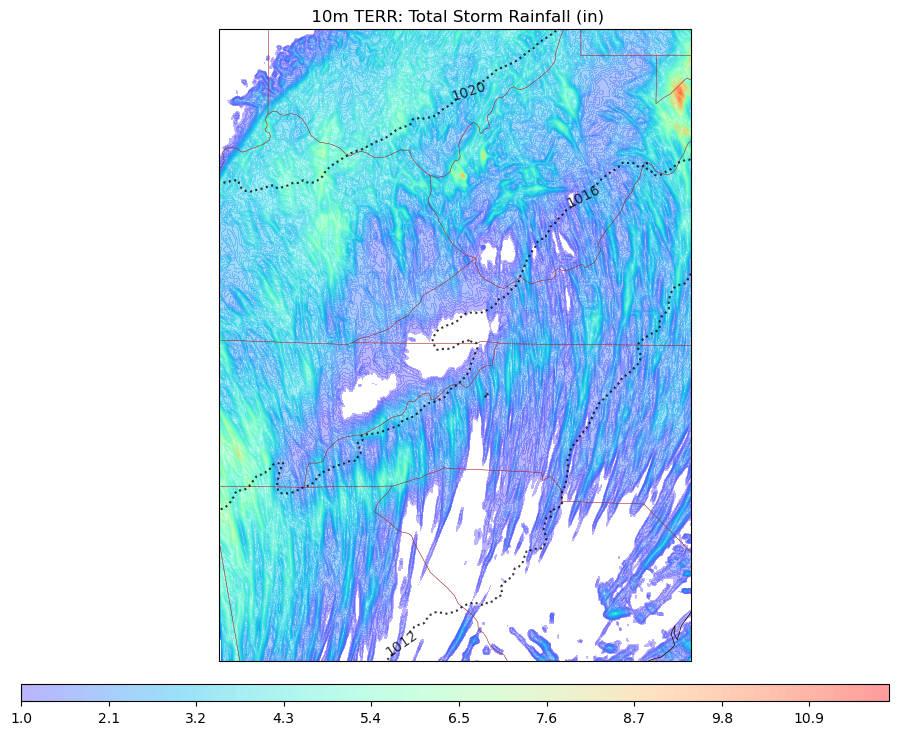

In [21]:
#FILE 2

#import file to compare
datafiles1 = (glob.glob("/scratch/amanda/ivan_lores_10m_terr/wrfout_d03_2004-09-19_00:00:00"))
datafiles1.sort()
numfiles1=len(datafiles1)
print(numfiles1)
print(datafiles1[0])

ivan_slp1=[]
ivan_rain1=[]
ivan_runoff1=[]
filetimes1=[]
for j in range(0,numfiles):
    ncfile1 = Dataset(datafiles1[j])
    Time1=wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    timestr1=(str(Time1))
    # Set up one time string for plot titles, another for file names
    titletime1=(timestr1[0:10]+' '+timestr1[11:16])
    filetime1=(timestr1[0:10]+'_'+timestr1[11:13])
    print('WRF valid time: ',filetime1)
    #print(ncfile)
    
    z1 = getvar(ncfile1, "z")
    dbz31 =getvar(ncfile1, "dbz")
    p1 = getvar(ncfile1, "pressure")
    slp1 = getvar(ncfile1, "slp")
    rainc1 = getvar(ncfile1, "RAINC")
    rainnc1 = getvar(ncfile1, "RAINNC")
    
    hires_terr1= ncfile1.variables["HGT"][0,:,:] #terrain height for the 30s terr resolution
    
    raintot1 = (rainc1 + rainnc1)*0.0393701 #in inches
    
    ivan_rain1.append(raintot1)
    filetimes1.append(filetime1)
    
    # Download and add the states and coastlines
    states = NaturalEarthFeature(category="cultural", scale="50m",facecolor="none", name="admin_1_states_provinces_shp")

    # Smooth the sea level pressure since it tends to be noisy near complex terrain
    smooth_slp1 = smooth2d(slp1, 3, cenweight=4)

    ivan_slp1.append(smooth_slp1)

    plotproj = crs.Mercator()
    fig = plt.figure(figsize=(14,10))
    ax=plt.subplot(111, projection=plotproj)
    ax.set_extent([-85.5, -79, 33, 40],crs.PlateCarree())
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.25, edgecolor='brown')
    ax.coastlines('50m', linewidth=0.4)
    
    #add contours 
    rain_levels = np.arange(1, 12, 0.1)
    pmsl_levels = np.arange(900, 1060, 4)
    contours = plt.contour(to_np(lons), to_np(lats), to_np(smooth_slp1), levels=pmsl_levels, colors="black", alpha= .8, linestyles='dotted',transform=crs.PlateCarree())
    plt.clabel(contours, inline=1, fontsize=10, fmt="%i") 
    
    
    rain_contours = plt.contourf(to_np(lons), to_np(lats), to_np(raintot1), levels=rain_levels,
                             cmap=get_cmap("rainbow"),norm=Normalize(0,12), vmin=0, vmax=12, alpha=.4,transform=crs.PlateCarree())
    plt.colorbar(rain_contours, ax=ax, orientation="horizontal", pad=.03, shrink=.8, aspect=50)

    plt.title(" 10m TERR: Total Storm Rainfall (in)")
    
    # Create separate plot file and save as .png, then show and close
    plt.savefig('plot_Lrterr_d03_'+filetime+'.png', dpi=300, bbox_inches='tight')

In [22]:
diff = raintot1-raintot
print(np.mean(diff))

<xarray.DataArray ()>
array(0.15527697, dtype=float32)
Coordinates:
    XTIME    float32 7.92e+03
    Time     datetime64[ns] 2004-09-19


7.192609034541722


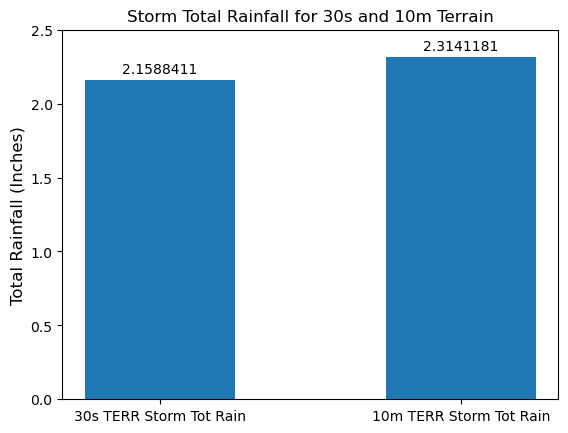

<Figure size 640x480 with 0 Axes>

In [23]:
# Data for the two bars
bar1 = 2.1588411 #raintot (hi res terr) storm total rainfall avg
bar2 = 2.3141181 #raintot1 (lo res terr) storm total rainfall avg

# Calculate the percent difference
percent_diff = ((bar2 - bar1) / bar1) * 100
print(percent_diff)

# Create bar chart
fig, ax = plt.subplots()
bars = ax.bar(["30s TERR Storm Tot Rain", "10m TERR Storm Tot Rain"], [bar1, bar2], width = 0.5)

# Add labels to the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f"{height}", xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                textcoords="offset points", ha="center", va="bottom")
ax.set_ylabel("Total Rainfall (Inches)", fontsize =12)
ax.set_ylim([0, 2.5])
# Add the percent difference as text above the bars
#ax.text(0.5, 1.05, f"{percent_diff:.1f}% difference", transform=ax.transAxes, ha="center")
plt.title('Storm Total Rainfall for 30s and 10m Terrain')
# Show the chart
plt.show()

plt.savefig('barchart_stormtotalraindiff_ivan.png', dpi=300, bbox_inches='tight')

In [24]:
#NOW, do AVG BOX analysis of this rainfall, compare to entire domain

In [25]:
#lats and lons to draw a box approx from cleveland, TN to winston salem, NC, with latitudes snapping the width of NC
#for avg box
start_lat = 34.9
end_lat=36.7
start_lon = -85.25
end_lon = -80.75

start_xy = ll_to_xy(ncfile, start_lat, start_lon, meta=False, as_int=True)
print(start_xy)

end_xy = ll_to_xy(ncfile, end_lat, end_lon, meta=False, as_int=True)
print(end_xy)

[ 21 195]
[331 341]


In [26]:
print(np.shape(ivan_rain))
print(numfiles)

(1, 630, 468)
1


In [11]:
#points for the smaller avg box (over southwest nc)
# istart=192
# iend=283 #seems to be latitudes (cuts east-west)
# jstart=107#seems to be longitudes (north-south boundaries)
# jend=211

In [28]:
#hi res terrain rain in avg box (FILE 1)
istart = 564
iend= 612
jstart = 171
jend = 274
rain_area3D=np.zeros([numfiles,48,103]) #define box area

for j in range(0,numfiles): #needs to match which files we imported variables for in above cells
    rain_area3D[j,:,:]=ivan_rain[j][istart:iend,jstart:jend]
    lonsra=lons[istart:iend,jstart:jend] #define lons and lats for plotting rainarea
    latsra=lats[istart:iend,jstart:jend]
    print(np.mean(rain_area3D[j,:,:]),':mean runoff in avg box at each time j(area)') #for plotting, probably just want to look at final time


print(np.shape(rain_area3D))
print(np.max(rain_area3D))
print(np.min(rain_area3D))

3.7494201489443917 :mean runoff in avg box at each time j(area)
(1, 48, 103)
5.288171768188477
2.096956729888916


In [31]:
#low res terrain rain in avg box (FILE 2)

rain_area3D1=np.zeros([numfiles1,48,103]) #look at the instantaneous runoff at times when Ivan has highest RRs in this region, and at times after (time lag?)

for j in range(0,numfiles1):
    rain_area3D1[j,:,:]=ivan_rain1[j][istart:iend,jstart:jend]
    lonsra=lons[istart:iend,jstart:jend] #define lons and lats for plotting rainarea
    latsra=lats[istart:iend,jstart:jend]
    print(np.mean(rain_area3D1[j,:,:]),':mean runoff in avg box at each time j(area)') #for plotting, probably just want to look at final time


print(np.shape(rain_area3D1))
print(np.max(rain_area3D1))
print(np.min(rain_area3D1))

3.6657754524722455 :mean runoff in avg box at each time j(area)
(1, 48, 103)
4.966744422912598
2.5672659873962402


9.96182092055423


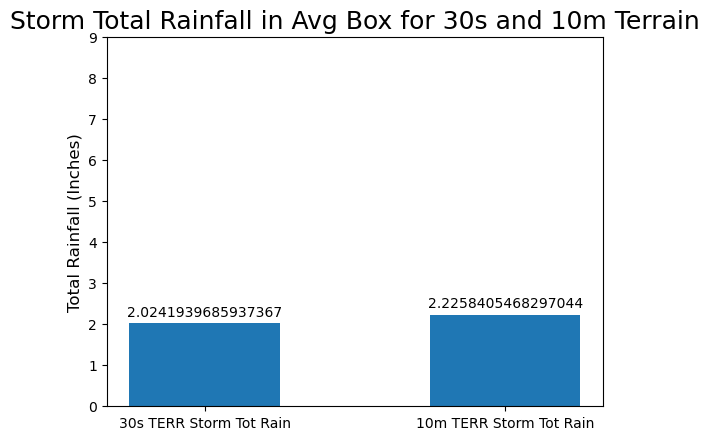

<Figure size 640x480 with 0 Axes>

In [33]:
# Data for the two bars from avg box
#bar1 = 7.614136324356218 #raintot (hi res terr) storm total rainfall avg #for smaller box
#bar2 = 7.392809818771967 #raintot1 (lo res terr) storm total rainfall avg

bar1 = 2.0241939685937367 #raintot (hi res terr) storm total rainfall avg
bar2 = 2.2258405468297044 #raintot1 (lo res terr) storm total rainfall avg

# Calculate the percent difference
percent_diff = ((bar2 - bar1) / bar1) * 100
print(percent_diff)
# Create the bar chart
fig, ax = plt.subplots()
bars = ax.bar(["30s TERR Storm Tot Rain", "10m TERR Storm Tot Rain"], [bar1, bar2], width = 0.5)

# Add labels to the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f"{height}", xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                textcoords="offset points", ha="center", va="bottom")
ax.set_ylabel("Total Rainfall (Inches)", fontsize =12)
ax.set_ylim([0, 9])
# Add the percent difference as text above the bars
#ax.text(0.5, 1.05, f"{percent_diff:.1f}% difference", transform=ax.transAxes, ha="center")
plt.title('Storm Total Rainfall in Avg Box for 30s and 10m Terrain',fontsize=18)
# Show the chart
plt.show()
#it is a 19.4% difference for all of d02 (but lots of zeros, 10m terr prod more)
#2.9 percent diff for my box (30s terr prod more)
plt.savefig('avgbox_barchart_stormtotalraindiff_d02_ivan.png', dpi=300, bbox_inches='tight')